In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

df.head(5)

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


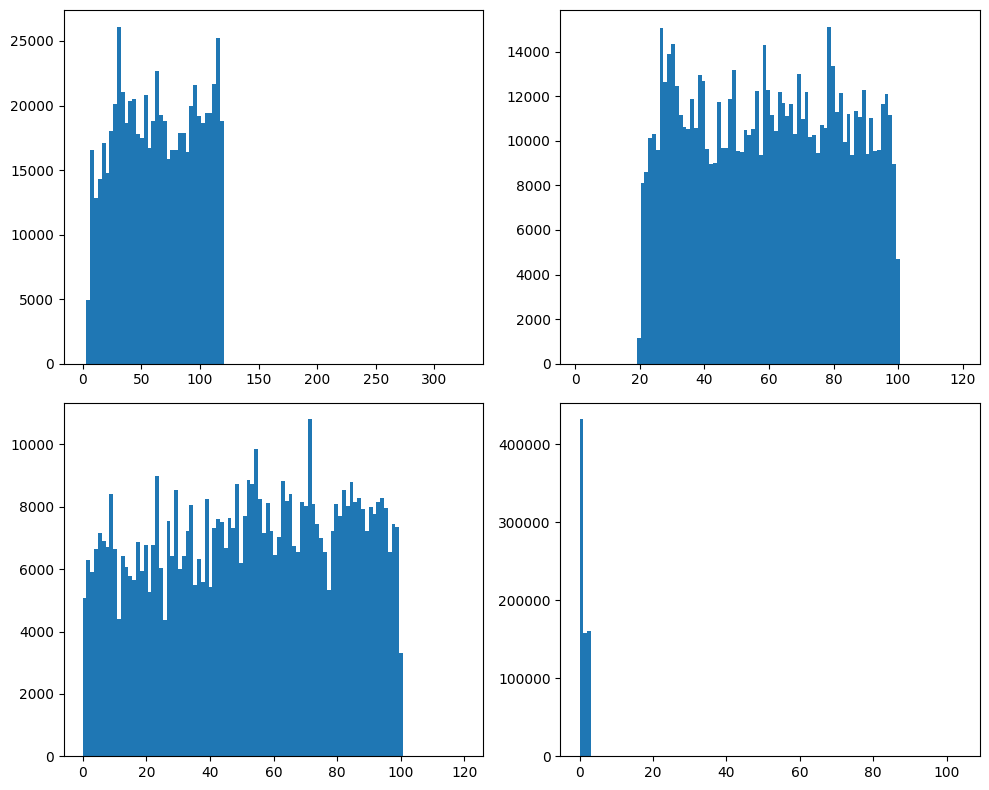

In [ ]:
numerical_columns = df.select_dtypes(include = ['int64', 'float64'])
categorical_columns = df.select_dtypes(include = ['object'])
numerical_columns = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_columns = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

plt.figure(figsize = (10,8))
for i, col in enumerate(numerical_columns, 1):
  plt.subplot(2, 2, i)
  plt.hist(df[col].dropna(), bins = 100)
plt.tight_layout()
plt.show()

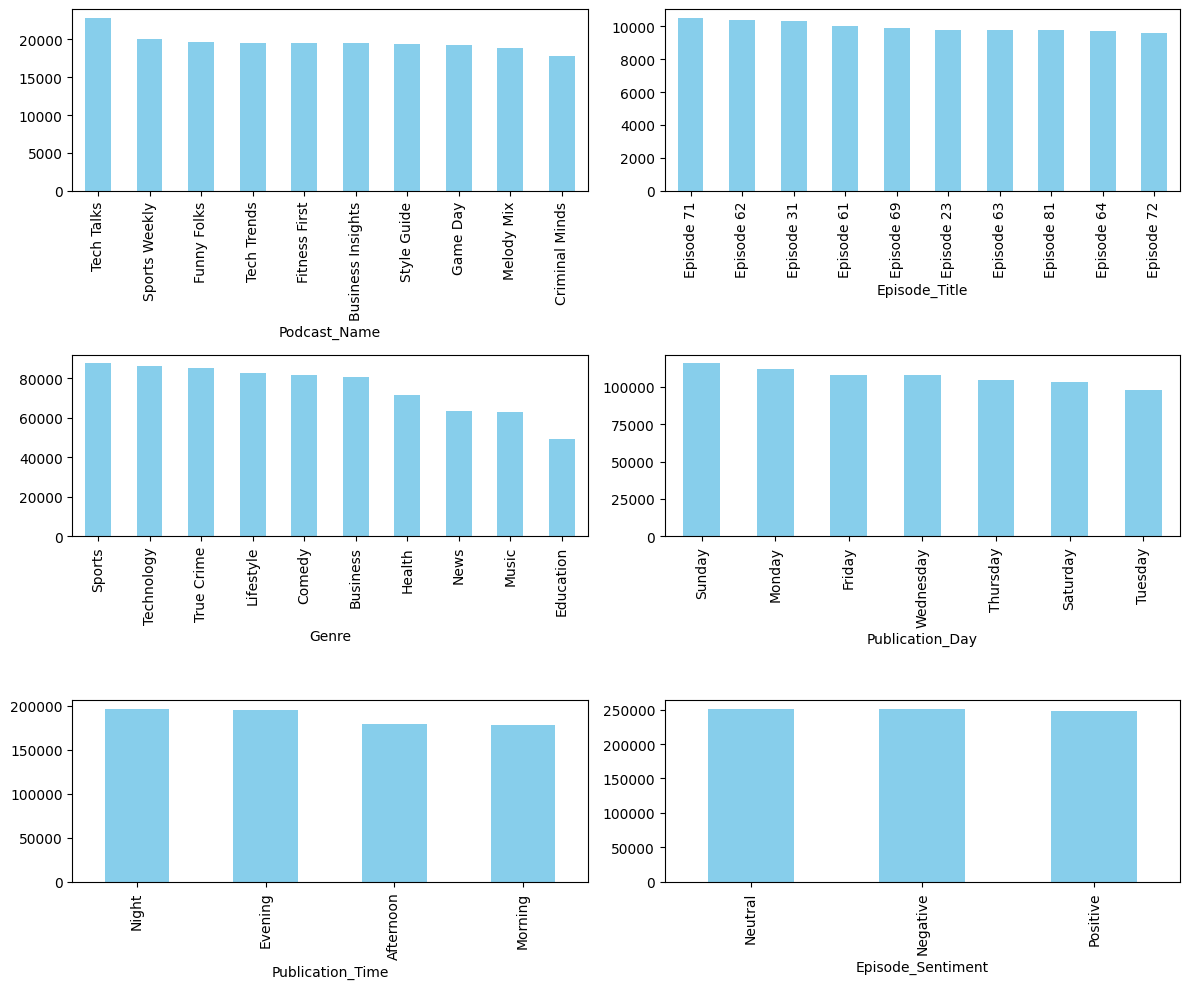

In [ ]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    df[col].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.tight_layout()
plt.show()

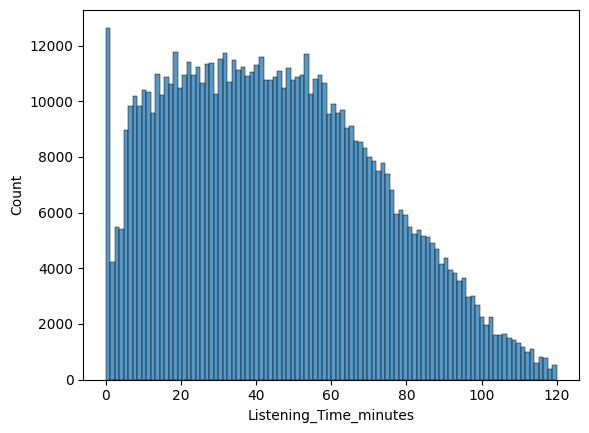

In [ ]:
plt.plot(figsize = (15, 4))
sns.histplot(df['Listening_Time_minutes'], bins = 100)
plt.show()

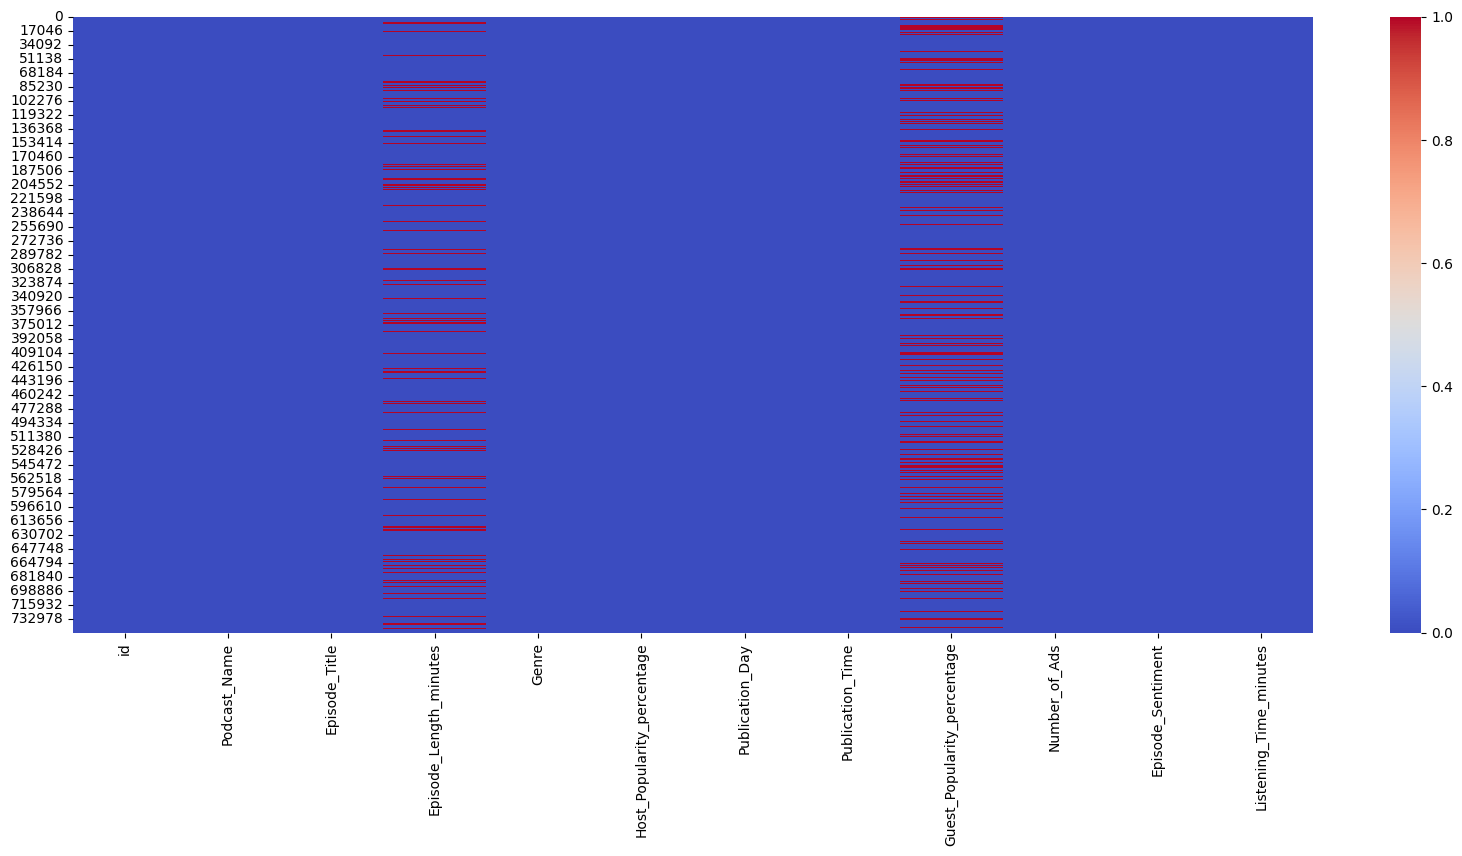

In [ ]:
plt.figure(figsize=(20, 8))
sns.heatmap(df.isnull(), cmap="coolwarm")
plt.show()

In [12]:
df['Episode_Length_minutes'] = df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].median())
df['Guest_Popularity_percentage'] = df['Guest_Popularity_percentage'].fillna(df['Episode_Length_minutes'].median())

mode_value = df["Number_of_Ads"].mode()[0]
df["Number_of_Ads"] = df["Number_of_Ads"].fillna(mode_value).astype(int)

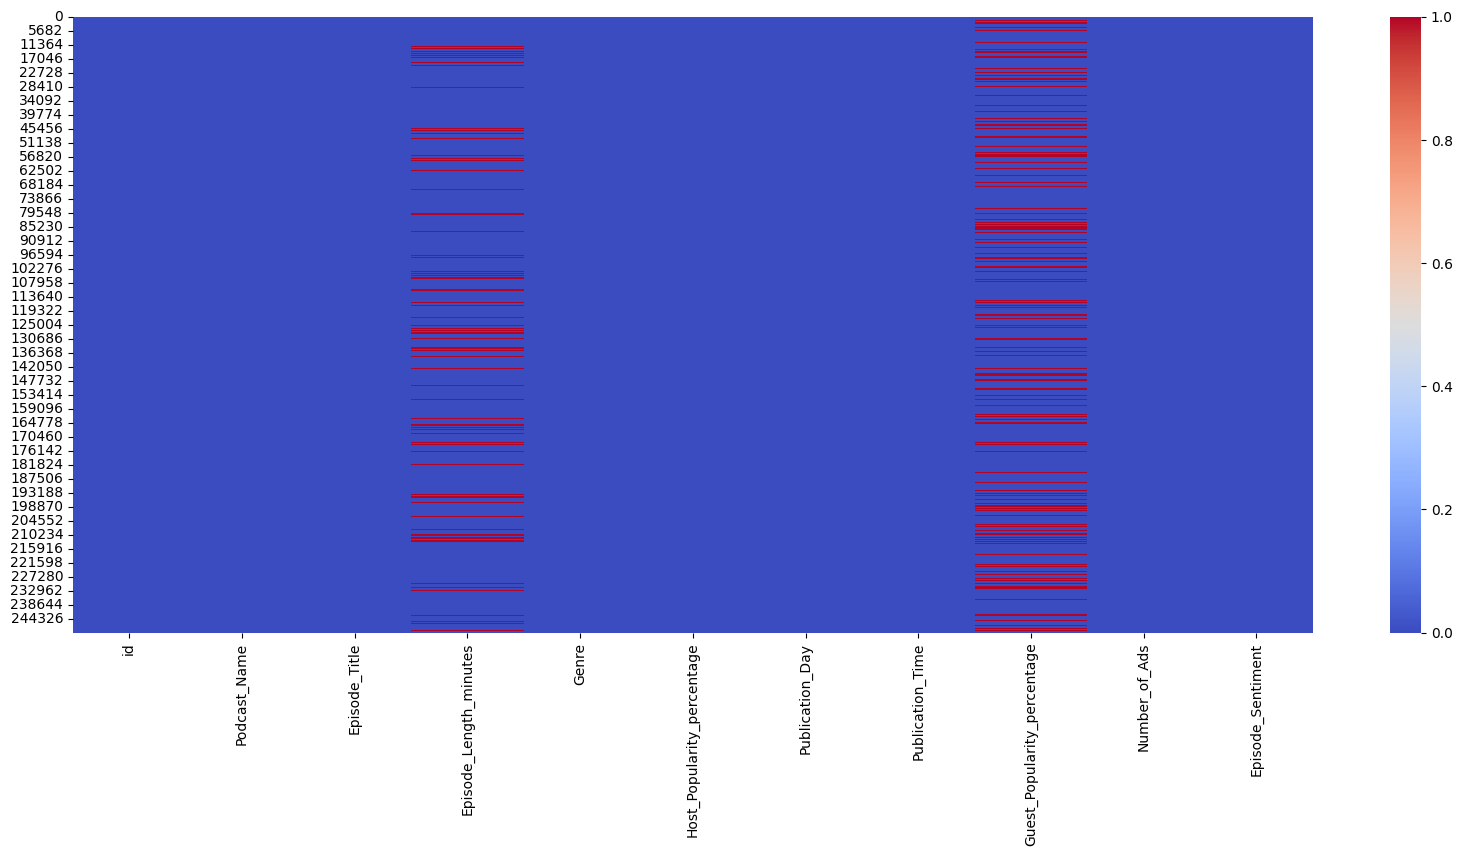

In [13]:
plt.figure(figsize = (20,8))
sns.heatmap(test_df.isnull(), cmap = 'coolwarm')
plt.show()

In [14]:
test_df['Episode_Length_minutes'] = test_df['Episode_Length_minutes'].fillna(test_df['Episode_Length_minutes'].median())
test_df['Guest_Popularity_percentage'] = test_df['Guest_Popularity_percentage'].fillna(test_df['Guest_Popularity_percentage'].median())

mode_value = test_df["Number_of_Ads"].mode()[0]
test_df["Number_of_Ads"] = test_df["Number_of_Ads"].fillna(mode_value).astype(int)

print(df.info(), test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       750000 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  750000 non-null  float64
 9   Number_of_Ads                750000 non-null  int64  
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 68.7+ MB


In [17]:
from itertools import combinations
from joblib import Parallel, delayed

df["Weekday"] = df["Publication_Day"].map({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})
df["SinWeekday"] = np.sin(2 * np.pi * df["Weekday"] / 7)
df["CosWeekday"] = np.cos(2 * np.pi * df["Weekday"] / 7)
df["Time"] = df["Publication_Time"].map({
    "Morning": 0,
    "Afternoon": 1,
    "Evening": 2,
    "Night": 3,
})

df["SinTime"] = np.sin(2 * np.pi * df["Time"] / 4)
df["CosTime"] = np.cos(2 * np.pi * df["Time"] / 4)

df["Episode_Title"] = df["Episode_Title"].str.split(" ", expand=True)[1].astype(np.uint16)
df["Number_of_Ads"] = df["Number_of_Ads"].fillna(0).clip(0, 3).astype(np.uint8)
df["Episode_Length_minutes"] = df['Episode_Length_minutes'].fillna(60)
df['SinEpLen'] = np.sin(2 * np.pi * df['Episode_Length_minutes'] / 60)
df['CosEpLen'] = np.cos(2 * np.pi * df['Episode_Length_minutes'] / 60)
del df["Publication_Time"], df["Publication_Day"]
df["ELen_Int"] = np.floor(df["Episode_Length_minutes"])
df["ELen_Dec"] = df["Episode_Length_minutes"] - df["ELen_Int"]
cat_cols = [
    "Podcast_Name", "Episode_Title", "Genre", "Number_of_Ads",
    "Episode_Sentiment", "ELen_Int"
]
df[cat_cols] = df[cat_cols].astype("string")
for col1, col2 in combinations(cat_cols, 2):
    df[f"{col1}-{col2}"] = df[col1] + "-" + df[col2]

In [18]:
test_df["Weekday"] = test_df["Publication_Day"].map({
    "Sunday": 0, "Monday": 1, "Tuesday": 2, "Wednesday": 3,
    "Thursday": 4, "Friday": 5, "Saturday": 6
})
test_df["SinWeekday"] = np.sin(2 * np.pi * test_df["Weekday"] / 7)
test_df["CosWeekday"] = np.cos(2 * np.pi * test_df["Weekday"] / 7)
test_df["Time"] = test_df["Publication_Time"].map({
    "Morning": 0, "Afternoon": 1, "Evening": 2, "Night": 3
})
test_df["SinTime"] = np.sin(2 * np.pi * test_df["Time"] / 4)
test_df["CosTime"] = np.cos(2 * np.pi * test_df["Time"] / 4)
test_df["Episode_Title"] = test_df["Episode_Title"].str.split(" ", expand=True)[1].astype(np.uint16)
test_df["Number_of_Ads"] = test_df["Number_of_Ads"].fillna(0).clip(0, 3).astype(np.uint8)
test_df["Episode_Length_minutes"] = test_df['Episode_Length_minutes'].fillna(60)
test_df['SinEpLen'] = np.sin(2 * np.pi * test_df['Episode_Length_minutes'] / 60)
test_df['CosEpLen'] = np.cos(2 * np.pi * test_df['Episode_Length_minutes'] / 60)
del test_df["Publication_Time"], test_df["Publication_Day"]
test_df["ELen_Int"] = np.floor(test_df["Episode_Length_minutes"])
test_df["ELen_Dec"] = test_df["Episode_Length_minutes"] - test_df["ELen_Int"]
test_df[cat_cols] = test_df[cat_cols].astype("string").fillna("missing")
for col1, col2 in combinations(cat_cols, 2):
    test_df[f"{col1}-{col2}"] = test_df[col1] + "-" + test_df[col2]

In [19]:
print(df.info(), test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               750000 non-null  int64  
 1   Podcast_Name                     750000 non-null  string 
 2   Episode_Title                    750000 non-null  string 
 3   Episode_Length_minutes           750000 non-null  float64
 4   Genre                            750000 non-null  string 
 5   Host_Popularity_percentage       750000 non-null  float64
 6   Guest_Popularity_percentage      750000 non-null  float64
 7   Number_of_Ads                    750000 non-null  string 
 8   Episode_Sentiment                750000 non-null  string 
 9   Listening_Time_minutes           750000 non-null  float64
 10  Weekday                          750000 non-null  int64  
 11  SinWeekday                       750000 non-null  float64
 12  Co

In [20]:
from sklearn.preprocessing import LabelEncoder

train = df
test = test_df
string_cols = [col for col in train.columns if train[col].dtype == 'string']
encoders = {}

for col in string_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    encoders[col] = le
for col in string_cols:
    if col in test.columns:
        le = encoders[col]
        test[col] = test[col].astype(str).map(
            lambda x: x if x in le.classes_ else '-1'
        ).map(
            {val: idx for idx, val in enumerate(np.append(le.classes_, '-1'))}
        ).astype(int)

df=train.copy()
te=test.copy()